1. pip install -e .
2. 輸入需要的 api key
   - openai_api_key
   - tavily_api_key

In [7]:
from typing import Annotated
import os
from IPython.display import Image, display
from typing_extensions import TypedDict

from langchain_tavily import TavilySearch
from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.checkpoint.memory import InMemorySaver

from langgraph.types import Command, interrupt
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import MessagesState
from langchain_core.runnables.config import RunnableConfig

from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = "your_key"
os.environ["TAVILY_API_KEY"] = "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"
chat_model_name = 'bedrock_converse:anthropic.claude-3-5-sonnet-20240620-v1:0'

In [8]:
llm = init_chat_model(model=chat_model_name)

search = TavilySearch(api_key=os.getenv("TAVILY_API_KEY"))

# llm 需要的 tools
tools = [
    TavilySearch(max_results=10),
    # human_assistance
    ]
llm_with_tool = llm.bind_tools(tools)

In [9]:
llm_with_tool.invoke("你好")

AIMessage(content='您好！很高兴为您服务。我是一位AI助手,可以回答您的问题或提供帮助。您有什么我可以为您做的吗?也许您想了解某个话题,或者需要某方面的建议?请随时告诉我,我会尽力协助您。', additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'dbe04f76-2780-440b-8fa0-d158eebed604', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 26 Aug 2025 01:53:00 GMT', 'content-type': 'application/json', 'content-length': '424', 'connection': 'keep-alive', 'x-amzn-requestid': 'dbe04f76-2780-440b-8fa0-d158eebed604'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [3959]}, 'model_name': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run--720d97a5-c407-4137-aadd-a5a5f65d0e74-0', usage_metadata={'input_tokens': 2101, 'output_tokens': 92, 'total_tokens': 2193, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})

In [10]:
search.invoke("川普")

{'query': '川普',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Donald_Trump',
   'title': 'Donald Trump',
   'content': 'Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.',
   'score': 0.60358196,
   'raw_content': None},
  {'url': 'https://www.backchina.com/infolist/news-800/',
   'title': '专题：川普总统最新动态！ - 美加',
   'content': '“川普好像在照着习近平的剧本做事” 美财长：美中关税谈判略停滞 需川普习近平参与 特朗普对中国留学生不留余地 中美再也回不到从前 德国主流媒体集体聚焦：特朗普令东南亚倒向中国 卡塔尔坚持：要写清楚飞机是特朗普政府主动要的 ## 川普-相关专题 ## “川普好像在照着习近平的剧本做事” 美国国务卿鲁比欧28日宣布，国务院将与国土安全部合作，大力撤销部分中国留美学生的签证，包含与中共有关联的陆生。 NBC新闻30日报道，这些陆生表示，他们正在质疑自己当初选择留学美国的决定。根据报道，受访的陆生表示，他们来到美国，是为了追求在中国大陆觉... ## 特朗普正在推动美中第二次“脱钩” 通过贸易战、出口管制和签证限制，特朗普政府正在发起一场更激进的脱钩运动，试图打破世界两大经济体之间的密切商业联系，并抛弃几十年来两国关系的支柱。 纽约时报中文网 (@nytchinese) May 30, 2025特朗普政府威胁要撤销在美约27.7... ## 美国上诉法院裁定特朗普关税措施目前可继续实施 美国一家上诉法院作出裁定，特朗普目前可以继续征收进口关税。此前一天，一项法院裁决认定他的大部分全球关税措施违法。  BB

In [11]:
# 定義 chatbot 如何回覆
# 包含 1. tools 設定
# 2. system prompt
def chatbot(state: MessagesState):
    # 加入 system prompt
    if not any(isinstance(msg, SystemMessage) for msg in state["messages"]):
        system_message = SystemMessage(content="""你是一個有幫助的AI助理。你可以使用搜尋工具來回答問題。
        當你需要最新資訊或事實查證時，請善用搜尋工具。請用繁體中文回答。""")
        state["messages"].insert(0, system_message)
    
    messages = llm_with_tool.invoke(state["messages"])
    return {"messages": messages}

In [12]:
# langgraph builder

graph_builder = StateGraph(state_schema=MessagesState)
tool_node = ToolNode(tools)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

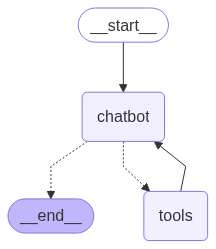

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
user_input = "GQR125CD 的車型是什麼，上網幫我搜尋一下"
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

response = graph.invoke(MessagesState(messages=[user_input]), config=config)

# llm 的回覆（response 會是歷史所有資料，最後一個是 llm 的回覆）
print(response['messages'][-1].content)

根據搜尋結果，我可以為您提供關於 GQR125CD 車型的以下資訊：

GQR125CD 是 Yamaha（台灣山葉機車）生產的一款車型，具體來說是 Cygnus Gryphus 系列的一部分。以下是關於這個車型的一些重要資訊：

1. 車型名稱：Yamaha Cygnus Gryphus（新勁戰）

2. 排氣量：125cc

3. 類型：速克達（Scooter）

4. 生產時間：根據召回資訊，這個車型是在 2021 年 10 月至 2024 年 10 月間生產的。

5. 特點：
   - 配備 LED 頭燈
   - 使用 CVT 變速系統（無段變速系統）
   - 有 ABS（防鎖死煞車系統）版本

6. 召回資訊：台灣山葉機車工業股份有限公司在 2024 年 2 月 20 日公告了一項召回，涉及 2021 年 10 月至 2022 年 10 月間生產的 GQR125CD 型號。召回原因是前煞車卡鉗製造過程中的部品管理問題，可能影響前煞車制動力。

7. 能源效率：這款車型曾獲得節能標章，但目前該證書已失效。當時的能源效率標準要求平均油耗需大於或等於 47.2 km/L。

8. 車架號碼範圍：根據召回資訊，受影響的 GQR125CD 車型的車架號碼範圍是 E32YE-078932 至 E32YE-117453。

GQR125CD 是 Yamaha 新勁戰系列中的一個具體型號，屬於在台灣市場銷售的 125cc 級別速克達。這款車型結合了現代設計、節能技術和安全特性，適合日常通勤和城市騎乘使用。


In [ ]:
# 結構化輸出 Structured Output
llmoutput -> sturctur output tools -> strured output